# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [10]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            #env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")


Episode: 1 Total reward: 9.0 Training loss: 1.2331 Explore P: 0.9991
Episode: 2 Total reward: 43.0 Training loss: 1.1311 Explore P: 0.9949
Episode: 3 Total reward: 15.0 Training loss: 1.2731 Explore P: 0.9934
Episode: 4 Total reward: 12.0 Training loss: 1.4160 Explore P: 0.9922
Episode: 5 Total reward: 17.0 Training loss: 1.2478 Explore P: 0.9905
Episode: 6 Total reward: 16.0 Training loss: 1.1191 Explore P: 0.9890
Episode: 7 Total reward: 24.0 Training loss: 1.1447 Explore P: 0.9866
Episode: 8 Total reward: 41.0 Training loss: 1.0616 Explore P: 0.9826
Episode: 9 Total reward: 11.0 Training loss: 1.0693 Explore P: 0.9816
Episode: 10 Total reward: 11.0 Training loss: 1.0125 Explore P: 0.9805
Episode: 11 Total reward: 13.0 Training loss: 1.2166 Explore P: 0.9792
Episode: 12 Total reward: 43.0 Training loss: 1.2557 Explore P: 0.9751
Episode: 13 Total reward: 17.0 Training loss: 1.2223 Explore P: 0.9734
Episode: 14 Total reward: 12.0 Training loss: 1.1893 Explore P: 0.9723
Episode: 15 Tota

Episode: 119 Total reward: 14.0 Training loss: 39.6774 Explore P: 0.7915
Episode: 120 Total reward: 10.0 Training loss: 34.3445 Explore P: 0.7907
Episode: 121 Total reward: 13.0 Training loss: 969.2113 Explore P: 0.7897
Episode: 122 Total reward: 15.0 Training loss: 41.0136 Explore P: 0.7885
Episode: 123 Total reward: 14.0 Training loss: 47.0375 Explore P: 0.7874
Episode: 124 Total reward: 17.0 Training loss: 437.4566 Explore P: 0.7861
Episode: 125 Total reward: 13.0 Training loss: 674.6246 Explore P: 0.7851
Episode: 126 Total reward: 35.0 Training loss: 211.7060 Explore P: 0.7824
Episode: 127 Total reward: 20.0 Training loss: 575.1499 Explore P: 0.7809
Episode: 128 Total reward: 76.0 Training loss: 31.4496 Explore P: 0.7750
Episode: 129 Total reward: 19.0 Training loss: 568.0919 Explore P: 0.7736
Episode: 130 Total reward: 14.0 Training loss: 419.1819 Explore P: 0.7725
Episode: 131 Total reward: 18.0 Training loss: 23.9569 Explore P: 0.7711
Episode: 132 Total reward: 9.0 Training loss

Episode: 235 Total reward: 20.0 Training loss: 202.5195 Explore P: 0.6696
Episode: 236 Total reward: 16.0 Training loss: 245.6224 Explore P: 0.6686
Episode: 237 Total reward: 9.0 Training loss: 198.5488 Explore P: 0.6680
Episode: 238 Total reward: 14.0 Training loss: 226.1106 Explore P: 0.6671
Episode: 239 Total reward: 24.0 Training loss: 94.3747 Explore P: 0.6655
Episode: 240 Total reward: 11.0 Training loss: 3.3624 Explore P: 0.6648
Episode: 241 Total reward: 13.0 Training loss: 2.9016 Explore P: 0.6639
Episode: 242 Total reward: 13.0 Training loss: 92.1189 Explore P: 0.6631
Episode: 243 Total reward: 15.0 Training loss: 3.1323 Explore P: 0.6621
Episode: 244 Total reward: 9.0 Training loss: 2.8381 Explore P: 0.6615
Episode: 245 Total reward: 21.0 Training loss: 88.8834 Explore P: 0.6602
Episode: 246 Total reward: 45.0 Training loss: 1.1308 Explore P: 0.6572
Episode: 247 Total reward: 14.0 Training loss: 88.6608 Explore P: 0.6563
Episode: 248 Total reward: 11.0 Training loss: 1.8169 

Episode: 348 Total reward: 10.0 Training loss: 78.6463 Explore P: 0.5550
Episode: 349 Total reward: 21.0 Training loss: 45.8003 Explore P: 0.5539
Episode: 350 Total reward: 16.0 Training loss: 88.5415 Explore P: 0.5530
Episode: 351 Total reward: 10.0 Training loss: 43.8319 Explore P: 0.5525
Episode: 352 Total reward: 13.0 Training loss: 2.0646 Explore P: 0.5518
Episode: 353 Total reward: 9.0 Training loss: 2.5882 Explore P: 0.5513
Episode: 354 Total reward: 15.0 Training loss: 37.3591 Explore P: 0.5505
Episode: 355 Total reward: 21.0 Training loss: 75.0297 Explore P: 0.5493
Episode: 356 Total reward: 9.0 Training loss: 148.1116 Explore P: 0.5488
Episode: 357 Total reward: 10.0 Training loss: 2.0512 Explore P: 0.5483
Episode: 358 Total reward: 33.0 Training loss: 2.4063 Explore P: 0.5465
Episode: 359 Total reward: 13.0 Training loss: 150.0139 Explore P: 0.5458
Episode: 360 Total reward: 24.0 Training loss: 1.8734 Explore P: 0.5445
Episode: 361 Total reward: 7.0 Training loss: 66.1419 Ex

Episode: 463 Total reward: 23.0 Training loss: 1.5381 Explore P: 0.3912
Episode: 464 Total reward: 62.0 Training loss: 13.1493 Explore P: 0.3889
Episode: 465 Total reward: 46.0 Training loss: 15.6930 Explore P: 0.3871
Episode: 466 Total reward: 40.0 Training loss: 0.7116 Explore P: 0.3856
Episode: 467 Total reward: 36.0 Training loss: 1.5739 Explore P: 0.3843
Episode: 468 Total reward: 41.0 Training loss: 29.6859 Explore P: 0.3827
Episode: 469 Total reward: 68.0 Training loss: 0.9298 Explore P: 0.3802
Episode: 470 Total reward: 48.0 Training loss: 54.3040 Explore P: 0.3784
Episode: 471 Total reward: 36.0 Training loss: 29.8353 Explore P: 0.3771
Episode: 472 Total reward: 54.0 Training loss: 15.6666 Explore P: 0.3751
Episode: 473 Total reward: 36.0 Training loss: 1.5114 Explore P: 0.3738
Episode: 474 Total reward: 33.0 Training loss: 1.2632 Explore P: 0.3726
Episode: 475 Total reward: 52.0 Training loss: 1.3502 Explore P: 0.3708
Episode: 476 Total reward: 27.0 Training loss: 1.5683 Expl

Episode: 577 Total reward: 15.0 Training loss: 1.9227 Explore P: 0.2254
Episode: 578 Total reward: 42.0 Training loss: 1.7017 Explore P: 0.2245
Episode: 579 Total reward: 40.0 Training loss: 1.7875 Explore P: 0.2237
Episode: 580 Total reward: 23.0 Training loss: 2.0012 Explore P: 0.2232
Episode: 581 Total reward: 23.0 Training loss: 1.8948 Explore P: 0.2227
Episode: 582 Total reward: 20.0 Training loss: 48.2482 Explore P: 0.2223
Episode: 583 Total reward: 21.0 Training loss: 69.6785 Explore P: 0.2218
Episode: 584 Total reward: 30.0 Training loss: 0.9095 Explore P: 0.2212
Episode: 585 Total reward: 34.0 Training loss: 71.9392 Explore P: 0.2205
Episode: 586 Total reward: 28.0 Training loss: 1.2803 Explore P: 0.2199
Episode: 587 Total reward: 25.0 Training loss: 1.2287 Explore P: 0.2194
Episode: 588 Total reward: 35.0 Training loss: 1.5259 Explore P: 0.2186
Episode: 589 Total reward: 59.0 Training loss: 1.1483 Explore P: 0.2174
Episode: 590 Total reward: 33.0 Training loss: 1.3741 Explore

Episode: 692 Total reward: 20.0 Training loss: 2.7871 Explore P: 0.1096
Episode: 693 Total reward: 15.0 Training loss: 3.2554 Explore P: 0.1094
Episode: 694 Total reward: 25.0 Training loss: 4.2556 Explore P: 0.1092
Episode: 695 Total reward: 22.0 Training loss: 2.1879 Explore P: 0.1090
Episode: 696 Total reward: 16.0 Training loss: 97.5934 Explore P: 0.1088
Episode: 697 Total reward: 25.0 Training loss: 2.4544 Explore P: 0.1086
Episode: 698 Total reward: 29.0 Training loss: 2.4440 Explore P: 0.1083
Episode: 699 Total reward: 16.0 Training loss: 2.6002 Explore P: 0.1081
Episode: 700 Total reward: 19.0 Training loss: 4.2409 Explore P: 0.1079
Episode: 701 Total reward: 17.0 Training loss: 2.6618 Explore P: 0.1078
Episode: 702 Total reward: 20.0 Training loss: 3.4306 Explore P: 0.1076
Episode: 703 Total reward: 18.0 Training loss: 175.1230 Explore P: 0.1074
Episode: 704 Total reward: 28.0 Training loss: 0.8834 Explore P: 0.1071
Episode: 705 Total reward: 30.0 Training loss: 2.7776 Explore

Episode: 805 Total reward: 174.0 Training loss: 0.7835 Explore P: 0.0367
Episode: 806 Total reward: 180.0 Training loss: 1.7869 Explore P: 0.0362
Episode: 807 Total reward: 171.0 Training loss: 1.9184 Explore P: 0.0357
Episode: 808 Total reward: 160.0 Training loss: 1.5157 Explore P: 0.0353
Episode: 809 Total reward: 142.0 Training loss: 1.7092 Explore P: 0.0350
Episode: 810 Total reward: 142.0 Training loss: 480.8442 Explore P: 0.0346
Episode: 811 Total reward: 131.0 Training loss: 1.9568 Explore P: 0.0343
Episode: 812 Total reward: 105.0 Training loss: 2.5484 Explore P: 0.0341
Episode: 813 Total reward: 24.0 Training loss: 2.2383 Explore P: 0.0340
Episode: 814 Total reward: 93.0 Training loss: 3.2810 Explore P: 0.0338
Episode: 815 Total reward: 101.0 Training loss: 1.6616 Explore P: 0.0335
Episode: 816 Total reward: 20.0 Training loss: 598.3972 Explore P: 0.0335
Episode: 817 Total reward: 95.0 Training loss: 2.7771 Explore P: 0.0333
Episode: 818 Total reward: 105.0 Training loss: 3.5

Episode: 921 Total reward: 61.0 Training loss: 1.3581 Explore P: 0.0210
Episode: 922 Total reward: 48.0 Training loss: 1.7233 Explore P: 0.0210
Episode: 923 Total reward: 59.0 Training loss: 4.5713 Explore P: 0.0209
Episode: 924 Total reward: 41.0 Training loss: 804.6906 Explore P: 0.0208
Episode: 925 Total reward: 34.0 Training loss: 4.3972 Explore P: 0.0208
Episode: 926 Total reward: 26.0 Training loss: 2.0439 Explore P: 0.0208
Episode: 927 Total reward: 199.0 Training loss: 1.6950 Explore P: 0.0206
Episode: 928 Total reward: 96.0 Training loss: 421.5662 Explore P: 0.0205
Episode: 929 Total reward: 199.0 Training loss: 430.5134 Explore P: 0.0203
Episode: 930 Total reward: 199.0 Training loss: 0.3908 Explore P: 0.0201
Episode: 931 Total reward: 199.0 Training loss: 5.0918 Explore P: 0.0199
Episode: 932 Total reward: 199.0 Training loss: 441.5955 Explore P: 0.0197
Episode: 933 Total reward: 199.0 Training loss: 0.4907 Explore P: 0.0195
Episode: 934 Total reward: 199.0 Training loss: 0.

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total Reward')

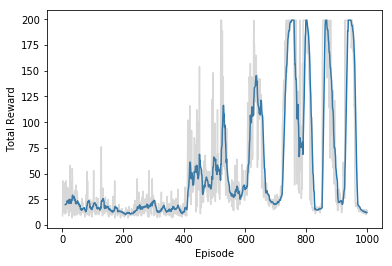

In [12]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [14]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints\cartpole.ckpt


In [15]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.